# Opening a Ramen Restaurant in New York City

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#Data)
* [Methodology](#Methodology)
* [Analysis](#Analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

<a id='introduction'></a>
## Introduction: Business Problem

Nowadays there is less and less stability in big companies and it is more common to become freelance and open your own business. Imagine that a person decide to leave his job in order to fulfill the dream of opening his own business. 

If the future owner considers that opening a restaurant would be a great option, it could be the best chance. However, many aspects come into play in this decision. Begining with the type of customers who will visit the restaurant or how many of them could be attended at the same time. Additionally, the food that will be served: it will be a restaurant with local food or with international lines. And finally, the location of the business. It is also an important feature in which city will be placed the local. If the owner wants to place it in a city that he gets used to it he will know where is the best area. But, probablly the most suitable city would not be this city. In order to decide the type and the place of the restaurant it is going to be made a tool to find the best solution.
In this tool it has considered that the restaurant will be an Ramen restaurant and it will compare the characteristic of the asian restaurants.

## Data

In this section, it is going to explain the source of the data that it will use in the case study. It is important to have a reliable source that provides the tool with real information. Mainly, the API used in this tool will be Foursquare. It is a technology company that built a massive dataset of location data. Its location data is the most comprehensive out there, and quite accurate that it powers location data for many popular services.

First of all, It is needed to obtain the coordinates of the city in study. New York city has 5 boroughs and 306 neighbourhoods, so in order to load this information it is going to load a dataset as json file with all the data. This data set is provided by IBM.

#### Sample of the coordinates dataset

|| Borough | Neighborhood | Latitude | Longitude 
|--- | --- | --- | --- | --- 
| 0 | Bronx | Wakefield | 40.894705 | -73.847201
| 1 | Bronx | Co-op City | 40.874294 | -73.829939
| 2 | Bronx | Eastchester | 40.887556 | -73.827806
| 3 | Bronx | Fieldston | 40.895437 | -73.905643
| 4 | Bronx | Riverdale | 40.890834 | -73.912585

These neghbourhoods could be seen in the figure below as blue circle marks:

<img src="NYC_map.png">

Once it has collected the neighborhood data, it will be used the Foursquare API to collect the Asian Restaurant information. First of all, it will used a get request to obtain the restaurant names. Then another request will be applied to obtain the rating of each restaurant.
The rating of the restaurants will be a good reason to decide where it could be located the business. The amount of restaurants in each neighborhood will also be used, if there is too much restaurants in one area is because there are a lot os customers with the same profile. Or may be an area with a few restaurants is a good opportunity to stand out with your business.

### Neighbourhood candidates and their restaurants:
First, import the libraries I will need and the data set.

In [1]:
import numpy as np 
# library to handle data in a vectorized manner

import pandas as pd 
# library for data analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!pip install geopy
#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans


!pip install shapely
import shapely.geometry

!pip install pyproj
import pyproj

import math

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported.')

!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')

with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    
    

def lonlat_to_xy(lon, lat):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
    return xy[0], xy[1]

def xy_to_lonlat(x, y):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
    return lonlat[0], lonlat[1]

def calc_xy_distance(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    return math.sqrt(dx*dx + dy*dy)

     |████████████████████████████████| 112kB 5.8MB/s eta 0:00:01
Libraries imported.
Data downloaded!
     |████████████████████████████████| 1.0MB 5.1MB/s eta 0:00:01


Now, time to transform de json file in a pandas dataframe

In [2]:
neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),neighborhoods.shape[0]))    
neighborhoods.head()

The dataframe has 5 boroughs and 306 neighborhoods.


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [3]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))
# create map of New York using latitude and longitude values
map_NYC = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the Boroughs
numBorough = 5
x = np.arange(numBorough)
ys = [i + x + (i*x)**2 for i in range(numBorough)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    if borough == 'Bronx': bor = 1
    if borough == 'Brooklyn': bor = 2
    if borough == 'Manhattan': bor = 3
    if borough == 'Queens': bor = 4
    if borough == 'Staten Island': bor = 5
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[bor-1],
        fill=True,
        fill_color=rainbow[bor-1],
        fill_opacity=0.7,
        parse_html=False).add_to(map_NYC)  
    
map_NYC

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


May be, All NYC its too much information for this project. Let's focus only in one Borough --> BROOKLYN

In [4]:
brooklyn_data = neighborhoods[neighborhoods['Borough'] == 'Brooklyn'].reset_index(drop=True)

address = 'Brooklyn New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Brooklyn, New York City are {}, {}.'.format(latitude, longitude))
# create map of New York using latitude and longitude values
map_Brooklyn = folium.Map(location=[latitude, longitude], zoom_start=11.5)

# add markers to map
for lat, lng, neighborhood in zip(brooklyn_data['Latitude'], brooklyn_data['Longitude'], brooklyn_data['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=500,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Brooklyn)  
    
map_Brooklyn

The geograpical coordinate of Brooklyn, New York City are 40.6501038, -73.9495823.


### Foursquare

Now, as the objective is opening a Ramen restaurant, it is a good way to search about restaurant of the same characteristics, Asian Restaurants. With all this data, we could see areas with low/high densisty of restaurants of this type, and also the evaluation that customers gave in their experiences.

In [5]:
CLIENT_ID = 'XXXXXXXX' # your Foursquare ID
CLIENT_SECRET = 'XXXXXXXXX' # your Foursquare Secret
ACCESS_TOKEN = 'XXXXXXXXXX' # your FourSquare Access Token

VERSION = '20180724' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
rest=[
 'Asian Restaurant','Cantonese Restaurant','Chinese Restaurant','Dim Sum Restaurant','Dumpling Restaurant',
 'Himalayan Restaurant','Indian Restaurant','Indonesian Restaurant','Japanese Curry Restaurant','Japanese Restaurant',
 'Korean Restaurant','Malay Restaurant','North Indian Restaurant','Ramen Restaurant','Shabu-Shabu Restaurant',
 'Shanghai Restaurant','Soba Restaurant','South Indian Restaurant','Sri Lankan Restaurant','Sushi Restaurant',
 'Szechuan Restaurant','Taiwanese Restaurant','Thai Restaurant','Tibetan Restaurant','Udon Restaurant',
 'Vietnamese Restaurant']
ramen_cat='55a59bace4b013909087cb24'
category_rest=['4bf58dd8d48988d142941735','52af3a7c3cf9994f4e043bed','4bf58dd8d48988d145941735','4bf58dd8d48988d1f5931735','4bf58dd8d48988d108941735',
               '52e81612bcbc57f1066b79fb','4bf58dd8d48988d10f941735','4deefc054765f83613cdba6f','55a59bace4b013909087cb30','4bf58dd8d48988d111941735',
               '4bf58dd8d48988d113941735','4bf58dd8d48988d156941735','54135bf5e4b08f3d2429dfdd','55a59bace4b013909087cb24','55a59bace4b013909087cb15',
               '52af3b593cf9994f4e043c00','55a59bace4b013909087cb27','54135bf5e4b08f3d2429dfde','5413605de4b0ae91d18581a9','4bf58dd8d48988d1d2941735',
               '52af3b773cf9994f4e043c03','52af3b813cf9994f4e043c04','4bf58dd8d48988d149941735','52af39fb3cf9994f4e043be9','55a59bace4b013909087cb2a',
               '4bf58dd8d48988d14a941735']
search_queries= pd.DataFrame(rest)


print('Lets search for Asian Restaurants in Brooklyn, NY')
print('The shape of the restaurants DataFrame is:',search_queries.shape)
search_queries.rename(columns= {0:'Asian Restaurants'},inplace=True)
search_queries.head()

Lets search for Asian Restaurants in Brooklyn, NY
The shape of the restaurants DataFrame is: (26, 1)


,Asian Restaurants
0,Asian Restaurant
1,Cantonese Restaurant
2,Chinese Restaurant
3,Dim Sum Restaurant
4,Dumpling Restaurant


In [6]:
def get_categories(categories):
    return [(cat['name'], cat['id']) for cat in categories]

def format_address(location):
    address = ', '.join(location['formattedAddress'])
    address = address.replace(', United States', '')
    return address

def get_venues_near_location(lat, lon, category):
    radius=500
    limit=100
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
        CLIENT_ID, CLIENT_SECRET, VERSION, lat, lon, category, radius, limit)

    try:
        results = requests.get(url).json()['response']['groups'][0]['items']
        venues = [(item['venue']['id'],
                   item['venue']['name'],
                   get_categories(item['venue']['categories']),
                   (item['venue']['location']['lat'], item['venue']['location']['lng']),
                   format_address(item['venue']['location']),
                   item['venue']['location']['distance']) for item in results]        
    except:
        venues = []
    return venues
import pickle

def get_restaurants(lats, lons, neighborhood):
    restaurants = {}
    Ramen_restaurants = {}
    location_restaurants = []

    print('Obtaining venues around locations:', end='')
    for category_res in category_rest:
        for lat, lon, neigh in zip(lats, lons, neighborhood):
            venues = get_venues_near_location(lat, lon, category_res)
            area_restaurants = []
            for venue in venues:
                is_Ramen = False
                venue_id = venue[0]
                venue_name = venue[1]
                venue_categories = venue[2]
                venue_latlon = venue[3]
                venue_address = venue[4]
                venue_distance = venue[5]
                for c in venue_categories:
                    category_name = c[0].lower()
                    if 'ramen restaurant' in category_name:
                        is_Ramen = True
                x, y = lonlat_to_xy(venue_latlon[1], venue_latlon[0])
                
                restaurant = (venue_id, venue_name, neigh, venue_latlon[0], venue_latlon[1], venue_address, venue_distance, is_Ramen, x, y)
                try:
                        if venue_distance<restaurants[venue_id][6]:
                            restaurants[venue_id] = restaurant
                            area_restaurants.append(restaurant)
                except:  
                        restaurants[venue_id] = restaurant
                        area_restaurants.append(restaurant)
                if is_Ramen:
                    Ramen_restaurants[venue_id] = restaurant
            location_restaurants.append(area_restaurants)
            print(' .', end='')
    print(' done.')
    return restaurants, Ramen_restaurants, location_restaurants

In [7]:
# Try to load from local file system in case we did this before
restaurants = {}
Ramen_restaurants = {}
location_restaurants = []
loaded = False
Latitudes= []
Longitudes= []
Latitudes = brooklyn_data['Latitude']
Longitudes = brooklyn_data['Longitude']
Neighborhoods = brooklyn_data['Neighborhood']

try:
    with open('restaurants_350.pkl', 'rb') as f:
        restaurants = pickle.load(f)
    with open('Ramen_restaurants_350.pkl', 'rb') as f:
        Ramen_restaurants = pickle.load(f)
    with open('location_restaurants_350.pkl', 'rb') as f:
        location_restaurants = pickle.load(f)
    print('Restaurant data loaded.')
    loaded = True
except:
    pass

# If load failed use the Foursquare API to get the data
if not loaded:
    restaurants, Ramen_restaurants, location_restaurants = get_restaurants(Latitudes, Longitudes,Neighborhoods)
    
    # Let's persists this in local file system
    with open('restaurants_350.pkl', 'wb') as f:
        pickle.dump(restaurants, f)
    with open('Ramen_restaurants_350.pkl', 'wb') as f:
        pickle.dump(Ramen_restaurants, f)
    with open('location_restaurants_350.pkl', 'wb') as f:
        pickle.dump(location_restaurants, f)
        
        
print('Total number of restaurants:', len(restaurants))
print('Total number of Ramen restaurants:', len(Ramen_restaurants))
print('Percentage of Ramen restaurants: {:.2f}%'.format(len(Ramen_restaurants) / len(restaurants) * 100))
print('Average number of restaurants in neighborhood:', np.array([len(r) for r in location_restaurants]).mean())

column=['Category id', 'Name','Neighborhood', 'Latitude','Longitude','Adress', 'Distance', 'is Ramen?', 'x', 'y']
df_restaurants=pd.DataFrame(columns=column)
key1=[];key2=[];key3=[];key4=[];key5=[];key6=[];key7=[];key8=[];key9=[];key10=[]
for key in restaurants:
    key1.append(restaurants[key][0]);key2.append(restaurants[key][1]);key3.append(restaurants[key][2])    
    key4.append(restaurants[key][3]);key5.append(restaurants[key][4]);key6.append(restaurants[key][5])
    key7.append(restaurants[key][6]);key8.append(restaurants[key][7]);key9.append(restaurants[key][8])  
    key10.append(restaurants[key][9])    
    
df_restaurants['Category id']= key1;df_restaurants['Name']= key2;df_restaurants['Neighborhood']= key3
df_restaurants['Latitude']= key4;df_restaurants['Longitude']= key5;df_restaurants['Adress']= key6
df_restaurants['Distance']= key7;df_restaurants['is Ramen?']= key8;df_restaurants['x']= key9
df_restaurants['y']= key10

df_restaurants.tail()

Restaurant data loaded.
Total number of restaurants: 650
Total number of Ramen restaurants: 19
Percentage of Ramen restaurants: 2.92%
Average number of restaurants in neighborhood: 0.3758241758241758


,Category id,Name,Neighborhood,Latitude,Longitude,Adress,Distance,is Ramen?,x,y
645,4d34a091c6cba35dec2f357a,Maison Premiere,North Side,40.714239,-73.961512,"298 Bedford Ave (btwn S 1st & Grand St), Brook...",237,False,-5.821879e+06,9.863867e+06
646,518eb55e498eef449a5a50f3,Shanghai Spa,Park Slope,40.674936,-73.981129,"241 5th Ave (Carroll Street), Brooklyn, NY 11215",450,False,-5.828618e+06,9.866218e+06
647,594277b586f4cc0f251fc389,DeKalb Market Hall,Downtown,40.691250,-73.982579,"445 Albee Sq, Brooklyn, NY 11201",87,False,-5.825854e+06,9.866481e+06
648,52687ae611d21eaf26051c81,Cats on the Bay,Sheepshead Bay,40.583824,-73.946849,"2027 Emmons Ave, Brooklyn, NY 11235",460,False,-5.843977e+06,9.861353e+06
649,4fb44e61e4b0557240bf1470,Mr. Piña Fruit and Vegetables,Williamsburg,40.709355,-73.959275,"219 Havemeyer St (at Broadway), Brooklyn, NY 1...",264,False,-5.822700e+06,9.863555e+06


Let's see the restaurants collected in the Brooklyn map, the red circles are the ramen restaurants:

In [8]:
address = 'Brooklyn New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Brooklyn, New York City are {}, {}.'.format(latitude, longitude))
# create map of New York using latitude and longitude values
map_Brok = folium.Map(location=[latitude, longitude], zoom_start=11.5)

folium.Marker(location=[latitude, longitude], popup='Brooklyn Center').add_to(map_Brok)
for res in restaurants.values():
    lat = res[3]; lon = res[4]
    is_Ramen = res[7]
    color = 'red' if is_Ramen else 'blue'
    folium.CircleMarker([lat, lon], radius=3, color=color, fill=True, fill_color=color, fill_opacity=1).add_to(map_Brok)
map_Brok


The geograpical coordinate of Brooklyn, New York City are 40.6501038, -73.9495823.


This finish the phase of capturing the data.

# Methodology

This tool is centered in helping the user in opening a Ramen restaurant in New York City, but particularly in the borough of Brooklyn. Once we obtain the neigborhood info and the restaurants in them, a good way to continue will be define the main criteria that we will have to decide the most suitable neighbourhoods to open it.
The first step was to select the area between the five boroughs of NYC. As Manhattan is too touristic and the user could not want this type of customer, it was decide Brooklyn.
In the second step, it was decide to compare the characteristics of the restaurants but specifically the asian restaurants. The asian restaurants could be a proper way because the loyal customers in the areas could have the taste that need to go to a Ramen restaurant.
In the next step it will be filtered the neighbourhood with specific characteristics in order to find the 3 most suitable neighborhood to open a new restaurant. Here, we will stablish the main criteria to select the proper area:
  - In the selected areas there must be more than 10 restaurants. It means that this neighborhood is where the customer is hoping a great variety of restaurants to choose which they feel like. And also if they go to their typical asian restautant they could see your new one and go other day. The distance to count the restaurants in the area will be 1 km.
  - In adition, as we can see in the previews information of the restaurants in Brooklyn there are only 19 Ramen restaurants so we will be required that there be any Ramen restaurant within 1 km.
  - And last, we will decide the three restaurants that fulfills this 2 conditions but the 3 with the best rating and the greates amount of likes.

# Analysis

First, we count the amount of restaurants in each neighbourhood:

In [9]:
location_restaurants_count = [len(res) for res in location_restaurants]
brooklyn_data.insert(4,'Restaurants in area',"")

for index in enumerate(brooklyn_data['Neighborhood']):
    brooklyn_data['Restaurants in area'].loc[index[0]] = location_restaurants_count[index[0]+(0*70)] + location_restaurants_count[index[0]+(1*70)] + location_restaurants_count[index[0]+(2*70)] + location_restaurants_count[index[0]+(3*70)] + location_restaurants_count[index[0]+(4*70)] + location_restaurants_count[index[0]+(5*70)] + location_restaurants_count[index[0]+(6*70)] + location_restaurants_count[index[0]+(7*70)] + location_restaurants_count[index[0]+(8*70)] + location_restaurants_count[index[0]+(9*70)] + location_restaurants_count[index[0]+(10*70)] + location_restaurants_count[index[0]+(11*70)] + location_restaurants_count[index[0]+(12*70)] + location_restaurants_count[index[0]+(13*70)] + location_restaurants_count[index[0]+(14*70)] + location_restaurants_count[index[0]+(15*70)] + location_restaurants_count[index[0]+(16*70)] + location_restaurants_count[index[0]+(17*70)] + location_restaurants_count[index[0]+(18*70)] + location_restaurants_count[index[0]+(19*70)] + location_restaurants_count[index[0]+(20*70)] + location_restaurants_count[index[0]+(21*70)] + location_restaurants_count[index[0]+(22*70)] + location_restaurants_count[index[0]+(23*70)] + location_restaurants_count[index[0]+(24*70)] + location_restaurants_count[index[0]+(25*70)]

print('Average number of restaurants in every area with radius=500m:', np.array(location_restaurants_count).mean())
brooklyn_data.head(10)

Average number of restaurants in every area with radius=500m: 0.3758241758241758


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Borough,Neighborhood,Latitude,Longitude,Restaurants in area
0,Brooklyn,Bay Ridge,40.625801,-74.030621,22
1,Brooklyn,Bensonhurst,40.611009,-73.995180,21
2,Brooklyn,Sunset Park,40.645103,-74.010316,10
3,Brooklyn,Greenpoint,40.730201,-73.954241,19
4,Brooklyn,Gravesend,40.595260,-73.973471,7
5,Brooklyn,Brighton Beach,40.576825,-73.965094,7
6,Brooklyn,Sheepshead Bay,40.586890,-73.943186,6
7,Brooklyn,Manhattan Terrace,40.614433,-73.957438,7
8,Brooklyn,Flatbush,40.636326,-73.958401,5
9,Brooklyn,Crown Heights,40.670829,-73.943291,2


Now, time to measure the distance to a Ramen Restaurant, the second condition.

In [10]:
xs=[]
ys=[]

for lon, lat in zip(brooklyn_data['Longitude'],brooklyn_data['Latitude']):
    x,y = lonlat_to_xy(lon,lat)
    xs.append(x)
    ys.append(y)
distances_to_ramen_restaurant = []

for area_x, area_y in zip(xs, ys):
    min_distance = 1000000000
    for res in Ramen_restaurants.values():
        res_x = res[8]
        res_y = res[9]
        d = calc_xy_distance(area_x, area_y, res_x, res_y)
        if d<min_distance:
            min_distance = d
    distances_to_ramen_restaurant.append(round(min_distance))

brooklyn_data['Distance to Ramen restaurant'] = distances_to_ramen_restaurant

restaurant_latlons = [[res[3], res[4]] for res in restaurants.values()]

ramen_latlons = [[res[3], res[4]] for res in Ramen_restaurants.values()]

print('Average distance to closest Ramen restaurant from each area center:', round(brooklyn_data['Distance to Ramen restaurant'].mean(),2))
brooklyn_data.head()

Average distance to closest Ramen restaurant from each area center: 4440.07


,Borough,Neighborhood,Latitude,Longitude,Restaurants in area,Distance to Ramen restaurant
0,Brooklyn,Bay Ridge,40.625801,-74.030621,22,8956
1,Brooklyn,Bensonhurst,40.611009,-73.995180,21,6474
2,Brooklyn,Sunset Park,40.645103,-74.010316,10,5128
3,Brooklyn,Greenpoint,40.730201,-73.954241,19,612
4,Brooklyn,Gravesend,40.595260,-73.973471,7,7868


In [11]:
from folium import plugins
from folium.plugins import HeatMap

map_brookl = folium.Map(location=[latitude, longitude], zoom_start=11.5)
folium.TileLayer('cartodbpositron').add_to(map_brookl) #cartodbpositron cartodbdark_matter
HeatMap(restaurant_latlons).add_to(map_brookl)
folium.Marker(location=[latitude, longitude]).add_to(map_brookl)
folium.Circle(location=[latitude, longitude], radius=1000, fill=False, color='white').add_to(map_brookl)
folium.Circle(location=[latitude, longitude], radius=2000, fill=False, color='white').add_to(map_brookl)
folium.Circle(location=[latitude, longitude], radius=3000, fill=False, color='white').add_to(map_brookl)
folium.Circle(location=[latitude, longitude], radius=4000, fill=False, color='white').add_to(map_brookl)
folium.Circle(location=[latitude, longitude], radius=5000, fill=False, color='white').add_to(map_brookl)
folium.Circle(location=[latitude, longitude], radius=6000, fill=False, color='white').add_to(map_brookl)

# add markers to map
for lat, lng, neighborhood in zip(brooklyn_data['Latitude'], brooklyn_data['Longitude'], brooklyn_data['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.2,
        parse_html=False).add_to(map_brookl)  
map_brookl

Finally, we count the amount of restaurants that there are in a radius of 1 km. This amount could be more than the restaurants of each neighbourhood because it could be that one restaurant in the closest neighborhood was located in less than 1 km of the neighborhood analyzed. 

In [12]:
 def count_restaurants_nearby(x, y, xres,yres, radius=1000):    
    count = 0
    for xres,yres in zip(xres,yres):
        d = calc_xy_distance(x, y, xres, yres)
        if d<=radius:
            count += 1
    return count


restaurant_counts = []
for x, y in zip(xs, ys):
    count = count_restaurants_nearby(x, y,df_restaurants['x'], df_restaurants['y'], radius=1000)
    restaurant_counts.append(count)

brooklyn_data['Restaurants nearby (less than 1 km)']=restaurant_counts
brooklyn_data.head()

,Borough,Neighborhood,Latitude,Longitude,Restaurants in area,Distance to Ramen restaurant,Restaurants nearby (less than 1 km)
0,Brooklyn,Bay Ridge,40.625801,-74.030621,22,8956,22
1,Brooklyn,Bensonhurst,40.611009,-73.995180,21,6474,21
2,Brooklyn,Sunset Park,40.645103,-74.010316,10,5128,10
3,Brooklyn,Greenpoint,40.730201,-73.954241,19,612,19
4,Brooklyn,Gravesend,40.595260,-73.973471,7,7868,7


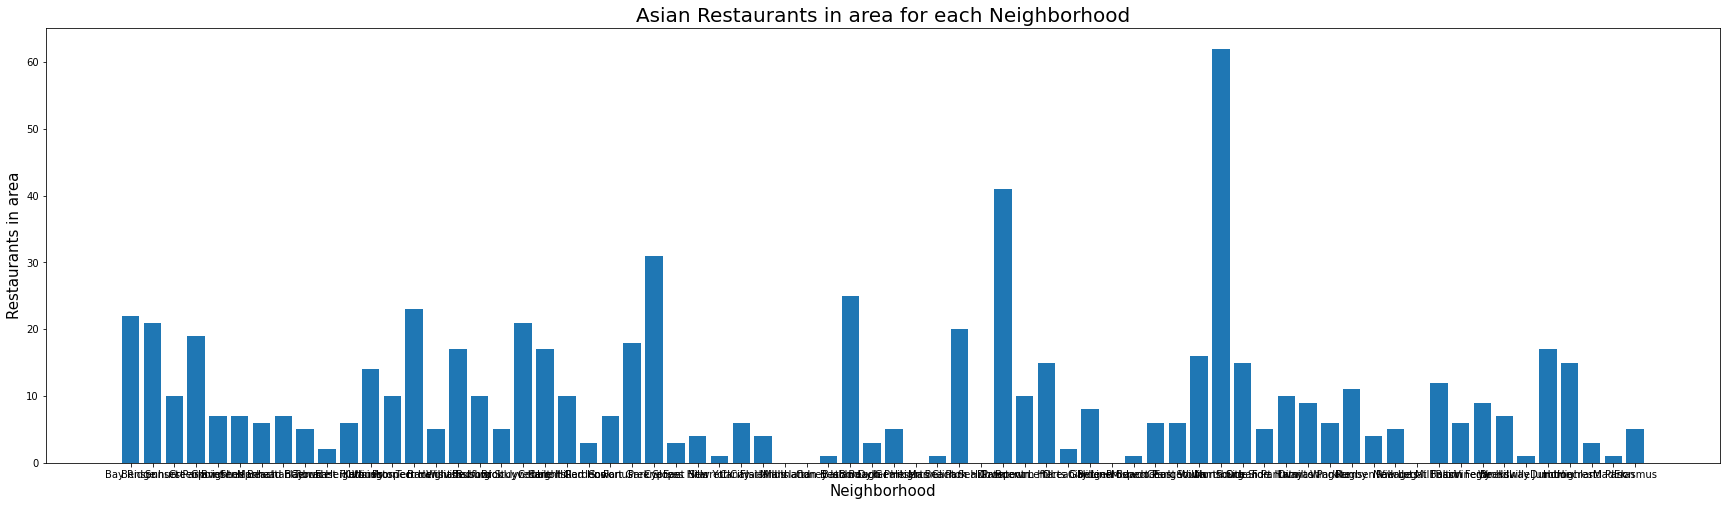

In [66]:
import matplotlib.pyplot as plt
x=brooklyn_data['Neighborhood']
y=brooklyn_data['Restaurants in area']
fig = plt.figure(figsize=(30,8))
plt.bar(x,y)
plt.title('Asian Restaurants in area for each Neighborhood', fontsize=20)
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('Restaurants in area', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

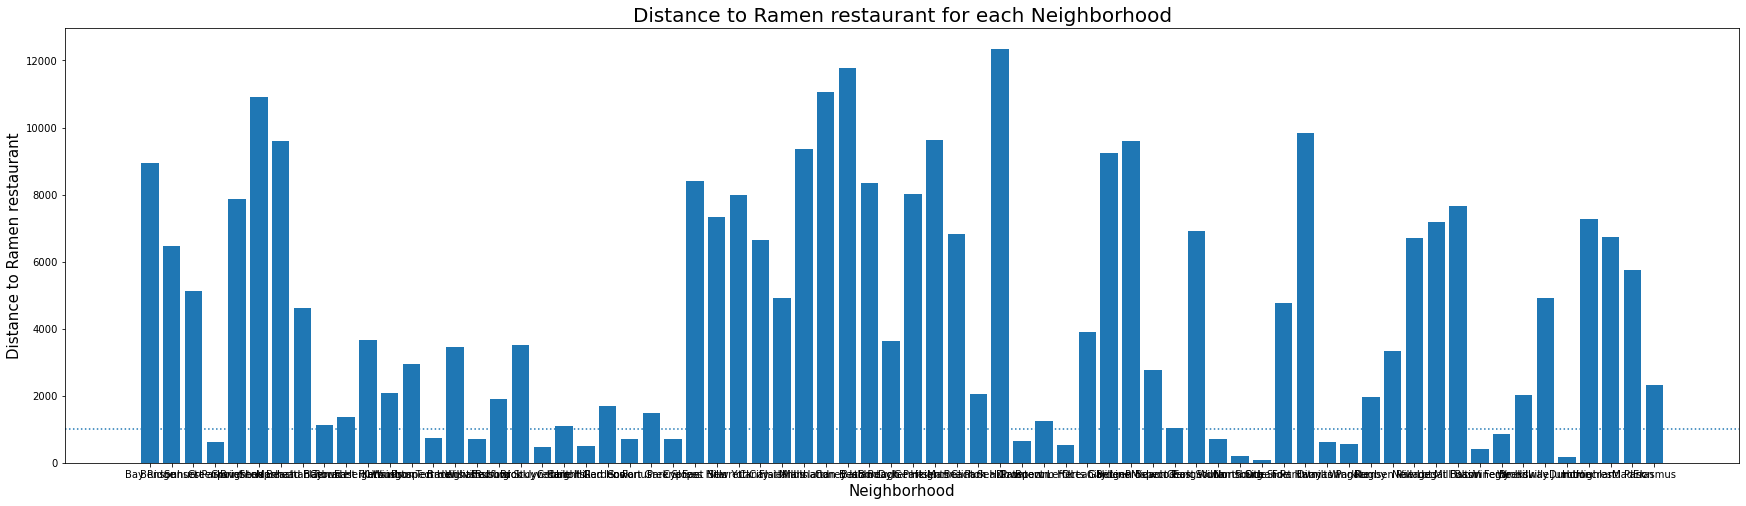

In [67]:
x=brooklyn_data['Neighborhood']
y=brooklyn_data['Distance to Ramen restaurant']
fig = plt.figure(figsize=(30,8))
plt.bar(x,y)
plt.axhline(y=1000, xmin=0, xmax=70,ls='dotted')
plt.title('Distance to Ramen restaurant for each Neighborhood', fontsize=20)
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('Distance to Ramen restaurant', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

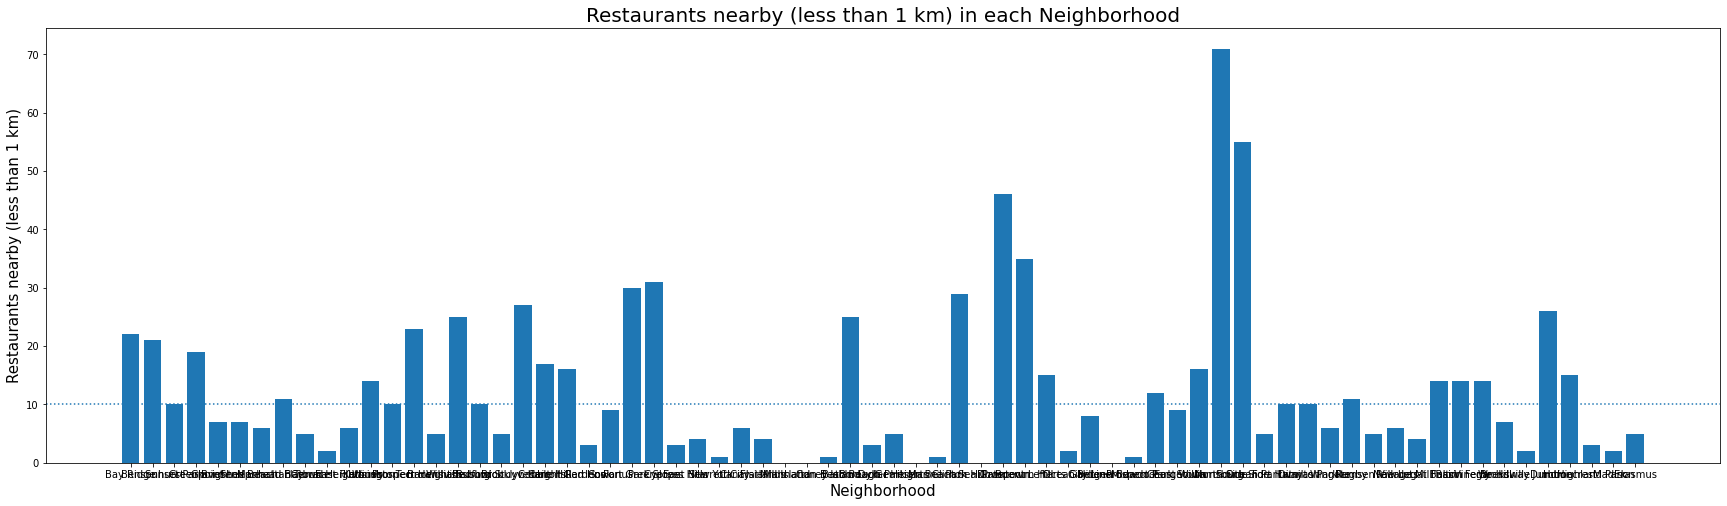

In [68]:
x=brooklyn_data['Neighborhood']
y=brooklyn_data['Restaurants nearby (less than 1 km)']
fig = plt.figure(figsize=(30,8))
plt.bar(x,y)
plt.axhline(y=10, xmin=0, xmax=70,ls='dotted')
plt.title('Restaurants nearby (less than 1 km) in each Neighborhood', fontsize=20)
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('Restaurants nearby (less than 1 km)', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

Now, with all this info we can filter the restaurants which fulfills the two conditions:
   - There are almost 10 restaurants in a radius of 1 km.
   - There is no Ramen restaurants in a radius of 1 km.


In [13]:
def_res_count = np.array((brooklyn_data['Restaurants nearby (less than 1 km)']>9))
print('Locations with more than 9 restaurants nearby:', def_res_count.sum())

def_ram_distance = np.array(brooklyn_data['Distance to Ramen restaurant']>=1000)
print('Locations with no Ramen restaurants within 1 km:', def_ram_distance.sum())

def_locations = np.logical_and(def_res_count, def_ram_distance)
print('Locations with both conditions met:', def_locations.sum())

def_locations = brooklyn_data[def_locations]
def_locations = def_locations.reset_index(drop=True)

Locations with more than 9 restaurants nearby: 32
Locations with no Ramen restaurants within 1 km: 53
Locations with both conditions met: 17


In [14]:
def restaurants_nearby(xs, ys , df_restaurants, radius=1000):    
    restaurants_near={}
    for x, y in zip(xs, ys):
        for cat,name,neighborhood,lat,lon,adre,dist,isra,xres,yres in zip(df_restaurants['Category id'],df_restaurants['Name'],df_restaurants['Neighborhood'],
                                                             df_restaurants['Latitude'],df_restaurants['Longitude'],
                                                             df_restaurants['Adress'],df_restaurants['Distance'],
                                                             df_restaurants['is Ramen?'],df_restaurants['x'],
                                                             df_restaurants['y']):
            d = calc_xy_distance(x, y, xres, yres)
            if d<=radius:
                restaurants_near[cat]=(cat,name,neighborhood,lat,lon,adre,dist,isra,xres,yres)
    return restaurants_near



def_restaurants_near = pd.DataFrame()
print('Generating data on location candidates... ', end='')
xloc=[]
yloc=[]

for lat,lon in zip(def_locations['Latitude'],def_locations['Longitude']):
    x1=[]
    y1=[]
    x1,y1 = lonlat_to_xy(lon,lat)
    xloc.append(x1)
    yloc.append(y1)
    

restaurants_near = restaurants_nearby(xloc,yloc, df_restaurants,radius=1000)

key1=[];key2=[];key3=[];key4=[];key5=[];key6=[];key7=[];key8=[];key9=[];key10=[]
for key in restaurants_near:
    key1.append(restaurants_near[key][0]);key2.append(restaurants_near[key][1])
    key3.append(restaurants_near[key][2]);key4.append(restaurants_near[key][3])
    key5.append(restaurants_near[key][4]);key6.append(restaurants_near[key][5])
    key7.append(restaurants_near[key][6]);key8.append(restaurants_near[key][7])
    key9.append(restaurants_near[key][8]);key10.append(restaurants_near[key][9])   

def_restaurants_near['Category id']= key1;   def_restaurants_near['Name']= key2
def_restaurants_near['Neighborhood']= key3;  def_restaurants_near['Latitude']= key4
def_restaurants_near['Longitude']= key5;     def_restaurants_near['Adress']= key6
def_restaurants_near['Distance']= key7;      def_restaurants_near['is Ramen?']= key8
def_restaurants_near['x']= key9;             def_restaurants_near['y']= key10

print('Number of restaurants to analyze:',len(def_restaurants_near))
def_restaurants_near.head()

Generating data on location candidates... Number of restaurants to analyze: 270


,Category id,Name,Neighborhood,Latitude,Longitude,Adress,Distance,is Ramen?,x,y
0,4a5beec3f964a52006bc1fe3,86 Noodles,Bay Ridge,40.622573,-74.028423,"8608 4th Ave (86th St.), Brooklyn, NY 11209",404,False,-5.837675e+06,9.872101e+06
1,5553702c498ecb85f99d8f37,XIN,Bay Ridge,40.625082,-74.030494,"8320 3rd Ave, Brooklyn, NY 11209",80,False,-5.837256e+06,9.872380e+06
2,50e8d45ae4b06202fbe39b08,Top Thai,Bay Ridge,40.623236,-74.028173,"4th Ave. (85th St.), Brooklyn, NY 11209",352,False,-5.837562e+06,9.872072e+06
3,4ec960ac9adf9c7bf54a9757,Golden Dragon,Bay Ridge,40.623726,-74.030655,"8523 3rd Ave, Brooklyn, NY 11209, Brooklyn, NY...",231,False,-5.837487e+06,9.872395e+06
4,4a73a072f964a520fbdc1fe3,Omiya,Bay Ridge,40.622329,-74.028576,"8618 4th Ave (Betw. 86th & 87th St.), Brooklyn...",423,False,-5.837717e+06,9.872120e+06


In [38]:
def_latitudes = def_locations['Latitude'].values
def_longitudes = def_locations['Longitude'].values

def_latlon = [[lat, lon] for lat, lon in zip(def_latitudes, def_longitudes)]

map_brooklyn = folium.Map(location=[latitude, longitude], zoom_start=12)
folium.TileLayer('cartodbpositron').add_to(map_brooklyn)
HeatMap(restaurant_latlons).add_to(map_brooklyn)
folium.Marker(location=[latitude, longitude]).add_to(map_brooklyn)
for lat, lon,neighborhood in zip(def_latitudes, def_longitudes,def_locations['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lon], radius=2,popup=label, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_brooklyn) 
map_brooklyn

Now, as we focus in these 17 neighbourhoods, we will obtain more information about the near restaurants. The rating that they have, the number of tips.

In [18]:
def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [19]:
column_names=['Neighborhood', 'ID','Name','Likes','Rating','Tips']
asian_rest_details=pd.DataFrame(columns=column_names)
count=1
asian_rest=def_restaurants_near.iloc[:,0:3]

for row in asian_rest.values.tolist():
    ID,Name,Neighborhood=row

    try:
        venue_details=get_venue_details(ID)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        id,name,likes,rating,tips=[0]*5
    
    asian_rest_details = asian_rest_details.append({
                                                'Neighborhood': Neighborhood,
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

asian_rest_details.to_csv('asian_rest_details.csv') # I continue to save data to a .csv as I move through this project
asian_rest_details.head()

,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bay Ridge,4a5beec3f964a52006bc1fe3,86 Noodles,19,7.4,22
1,Bay Ridge,5553702c498ecb85f99d8f37,XIN,6,7.3,4
2,Bay Ridge,50e8d45ae4b06202fbe39b08,Top Thai,14,7.1,11
3,Bay Ridge,0,0,0,0.0,0
4,Bay Ridge,4a73a072f964a520fbdc1fe3,Omiya,18,7.4,9


In [20]:
asian_rest_details.tail()

,Neighborhood,ID,Name,Likes,Rating,Tips
265,Homecrest,4f3c5cb4e4b02d5ef78d79bc,Sushi MiKasa,8,6.5,6
266,Homecrest,0,0,0,0.0,0
267,Homecrest,0,0,0,0.0,0
268,Homecrest,0,0,0,0.0,0
269,Homecrest,0,0,0,0.0,0


From all of these restaurants there are a few without information, in order to avoid wrong results in the average data, we will drop them.

In [21]:
asian_rest_details['Likes']=asian_rest_details['Likes'].astype('float64')
asian_rest_details['Tips']=asian_rest_details['Tips'].astype('float64')
# Get names of indexes for which column Rating has value 0
indexNames = asian_rest_details[ asian_rest_details['ID'] == 0 ].index
# Delete these row indexes from dataFrame
asian_rest_details.drop(indexNames , inplace=True)
asian_rest_details=asian_rest_details.reset_index(drop=True)
asian_rest_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Neighborhood  116 non-null    object 
 1   ID            116 non-null    object 
 2   Name          116 non-null    object 
 3   Likes         116 non-null    float64
 4   Rating        116 non-null    float64
 5   Tips          116 non-null    float64
dtypes: float64(3), object(3)
memory usage: 5.6+ KB


In [22]:
asian_rest_details.describe()

,Likes,Rating,Tips
count,116.000000,116.000000,116.000000
mean,47.491379,7.068103,18.146552
std,100.298294,1.081914,27.537249
min,0.000000,4.900000,0.000000
25%,5.750000,6.200000,4.000000
50%,17.000000,7.050000,7.000000
75%,38.500000,7.825000,19.000000
max,778.000000,9.200000,159.000000


The restaurants with the best clasifications are:

In [23]:
# Resturant with maximum Likes
asian_rest_details.iloc[asian_rest_details['Likes'].idxmax()]
# Resturant with maximum Ratings
asian_rest_details.iloc[asian_rest_details['Rating'].idxmax()]
# Resturant with maximum Tips
asian_rest_details.iloc[asian_rest_details['Tips'].idxmax()]

col=['Clasification','Neighborhood','Name','Likes','Rating','Tips']
max_rest=pd.DataFrame(columns=col)
Clas=['Max Ratings','Max Likes','Max Tips']
likemax=pd.DataFrame()
likemax=asian_rest_details[asian_rest_details['Likes']==asian_rest_details['Likes'].max()]
ratmax=asian_rest_details[asian_rest_details['Rating']==asian_rest_details['Rating'].max()]
tipmax=asian_rest_details[asian_rest_details['Tips']==asian_rest_details['Tips'].max()]


max_rest.loc[0]=[Clas[0],likemax.iloc[0,0],likemax.iloc[0,2],likemax.iloc[0,3],likemax.iloc[0,4],likemax.iloc[0,5]]
max_rest.loc[1]=[Clas[1],ratmax.iloc[0,0],ratmax.iloc[0,2],ratmax.iloc[0,3],ratmax.iloc[0,4],ratmax.iloc[0,5]]
max_rest.loc[2]=[Clas[2],tipmax.iloc[0,0],tipmax.iloc[0,2],tipmax.iloc[0,3],tipmax.iloc[0,4],tipmax.iloc[0,5]]

max_rest

,Clasification,Neighborhood,Name,Likes,Rating,Tips
0,Max Ratings,Downtown,DeKalb Market Hall,778.0,9.2,106.0
1,Max Likes,Downtown,DeKalb Market Hall,778.0,9.2,106.0
2,Max Tips,Cobble Hill,Joya,318.0,8.3,159.0


Now, we can choose the first neighborhood with the best average Rating:

In [24]:
ny_neighborhood_statsRating=asian_rest_details.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_statsRating.columns=['Neighborhood','Average Rating']
ny_neighborhood_statsRating.sort_values(['Average Rating'],ascending=False)

,Neighborhood,Average Rating
12,Kensington,8.175000
5,Clinton Hill,7.523077
9,Fort Greene,7.455556
8,Downtown,7.333333
14,Mill Basin,7.333333
6,Cobble Hill,7.246154
3,Boerum Hill,7.216667
7,Ditmas Park,7.150000
1,Bay Ridge,7.066667
10,Fort Hamilton,6.914286


In second and third position we could choose the restaurants with the highest amount of Likes and Tips.

In [32]:
ny_neighborhood_stats=asian_rest_details.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Likes']]
ny_neighborhood_stats.columns=['Neighborhood','Average Likes']
ny_neighborhood_stats.sort_values(['Average Likes'],ascending=False)

,Neighborhood,Average Likes
6,Cobble Hill,110.923077
9,Fort Greene,106.777778
8,Downtown,88.800000
5,Clinton Hill,44.153846
7,Ditmas Park,36.750000
17,Windsor Terrace,34.800000
3,Boerum Hill,34.666667
12,Kensington,26.000000
10,Fort Hamilton,16.857143
2,Bensonhurst,15.600000


In [33]:
ny_neighborhood_stats=asian_rest_details.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Tips']]
ny_neighborhood_stats.columns=['Neighborhood','Average Tips']
ny_neighborhood_stats.sort_values(['Average Tips'],ascending=False)

,Neighborhood,Average Tips
6,Cobble Hill,45.846154
9,Fort Greene,33.555556
5,Clinton Hill,23.307692
7,Ditmas Park,21.750000
12,Kensington,20.750000
17,Windsor Terrace,15.400000
8,Downtown,15.266667
3,Boerum Hill,12.333333
1,Bay Ridge,10.222222
10,Fort Hamilton,9.285714


In [39]:
selected_neighs=['Downtown','Cobble Hill','Kensington']

definitve_neighs = brooklyn_data[brooklyn_data.Neighborhood.isin(selected_neighs)]
definitve_latitudes = definitve_neighs['Latitude'].values
definitive_longitudes = definitve_neighs['Longitude'].values

def_latlon = [[lat, lon] for lat, lon in zip(definitve_latitudes, definitive_longitudes)]

map_brooklyn = folium.Map(location=[latitude, longitude], zoom_start=12)
folium.TileLayer('cartodbpositron').add_to(map_brooklyn)
HeatMap(restaurant_latlons).add_to(map_brooklyn)
folium.Marker(location=[latitude, longitude]).add_to(map_brooklyn)
for lat, lon,neighborhood in zip(definitve_latitudes, definitive_longitudes,selected_neighs):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lon], radius=2,popup=label, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_brooklyn) 
map_brooklyn

<a id='results'></a>
## Results and Discussion

With the analysis done, it could be say that there are a few neighborhoods to stablish a new Ramen restaurant. It has been decided to obtain the best three areas that fulfill all the requirements imposed. These requirements were:
   - The neighborhood should have the nearest Ramen restaurant 1 km away.
   - This area should have at least 10 restaurants within an area with a radius of 1 km.

Aplying the requirements there are 17 neighborhoods in which we could open the desire restaurant. But in order to give a better area we have compared the evaluation of the restaurants that there are in the neighborhood previusly selected. The criteria used in the evaluations was the rating, the amount of likes and the amount of tips of each restaurant. 

<a id='conclusion'></a>
## Conclusion

The restaurant which has the best rating is 'DeKalb Market Hall' which in fact has the most likes also. This restaurants is located in de Downtown neighborhood, so this area will be selected as a proper space to open it. Besides, the neighborhood which has the most average rating is Kensigton so it will be also selected. The same with Cobble Hill that has the best average Likes and Tips. In Cobble Hill there is also the restaurant which has the best amount of Tips, called 'Joya'.
Finally, the neughborhood selectes are:
   - Downtown
   - Kensington
   - Cobble Hill